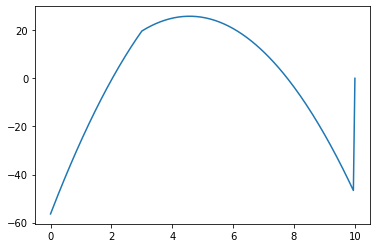

In [72]:
import re
import streamlit as st
from sympy.physics.continuum_mechanics import Beam
import sympy
from sympy import SingularityFunction
from sympy.plotting import plot
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

st.write("""
# Simple Beam Analysis

""")

st.sidebar.header('User Input Parameters')

def user_input_features(): 
    # Beam Length in Meters
    beam_length = st.sidebar.slider('Beam Length', 5.0, 25.0, 10.0, step=2.5)
    # Start Supports
    start_Support = st.sidebar.selectbox('Start Support',('Fix', 'Pin', 'Roller'))
    end_Support = st.sidebar.selectbox('End Support',('Fix', 'Pin'))

    #Point Load in kN
    point_load = st.sidebar.slider('Point Load Magnitude', 0.0, 25.0, 10.0, step=5.0)

    point_load_loc = st.sidebar.slider('Point Load Loc:', 0.0, beam_length, 3.0, step=2.5)
    
    # Udl load is in kN/m
    udl_load = st.sidebar.slider('UDL Magnitude', 0.0, 25.0, 5.0 ,step = 5.0)

    udl_start_loc = st.sidebar.slider('UDL Start Loc', 0.0, beam_length - 5.0, 0.0, step=2.5)
    udl_end_loc = st.sidebar.slider('UDL End Loc', udl_start_loc+2.5, beam_length, beam_length, step=2.5)

    #Point Load in kN-m
    moment_load = st.sidebar.slider('Moment Magnitude', -20.0, 20.0, 0.0, step=5.0)

    moment_loc = st.sidebar.slider('Moment Loc:', 0.0, beam_length, 4.0, step=2.5)

    
    data = {'beam_length': beam_length,
            'start_Support': start_Support,
            'end_Support': end_Support,
            'E': 25000.0,
            'Izz': 0.0005}

    features = pd.DataFrame(data, index=[0])
    beam_data = [beam_length, start_Support, end_Support]

    point_data = [point_load, point_load_loc]
    
    moment_data = [moment_load, moment_loc]
    
    UDL_data = [udl_load, udl_start_loc, udl_end_loc]

    return features, beam_data, point_data, moment_data, UDL_data

df, beam_data, point_data, moment_data, UDL_data = user_input_features()

st.subheader('User Input parameters')
st.write(df)

# Logic
E = 25000
I = 0.0005

#print(beam_data, point_data)

L = beam_data[0]
lt_sprt = beam_data[1]
rt_sprt = beam_data[2]

beam_inst = Beam(L, E, I)

def sympy_variable(x:str):
        return sympy.symbols(x)

def apply_end_support_loads(beam_inst, L):
    sympy_symbols = []
    beam_inst.bc_deflection = []
    beam_inst.bc_slope = []
    if lt_sprt == "Fix":
        R_0 = sympy_variable("R_0")
        M_0 = sympy_variable("M_0")
        sympy_symbols.append(R_0)
        sympy_symbols.append(M_0)
        beam_inst.apply_load(R_0, 0, -1)
        beam_inst.apply_load(M_0, 0, -2)
        beam_inst.bc_deflection.append((0,0))
        beam_inst.bc_slope.append((0,0))
    else:
        R_0 = sympy_variable("R_0")
        sympy_symbols.append(R_0)
        beam_inst.apply_load(R_0, 0, -1)
        beam_inst.bc_deflection.append((0,0))

    if rt_sprt == "Fix":
        r_end = sympy_variable("R_" + str(L))
        m_end = sympy_variable("M_" + str(L))
        sympy_symbols.append(r_end)
        sympy_symbols.append(m_end)
        beam_inst.apply_load(r_end, L, -1)
        beam_inst.apply_load(m_end, L, -2)
        beam_inst.bc_deflection.append((L,0))
        beam_inst.bc_slope.append((L,0))
    else:
        r_end = sympy_variable("R_" + str(L))
        sympy_symbols.append(r_end)
        beam_inst.apply_load(r_end, L, -1)
        beam_inst.bc_deflection.append((L,0))
    
    return sympy_symbols

reaction_symbols = apply_end_support_loads(beam_inst ,L)


beam_inst.apply_load(point_data[0], point_data[1], -1)
beam_inst.apply_load(moment_data[0], moment_data[1], -2)
beam_inst.apply_load(UDL_data[0], UDL_data[1], 0, end=UDL_data[2])

#beam_inst.load
draw_pen = beam_inst.draw(pictorial=True)
#draw_pen.save("default.png")

#print(reaction_symbols[0] == sympy_variable("R_0"))


if len(reaction_symbols) == 4:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1] ,reaction_symbols[2], reaction_symbols[3])
elif len(reaction_symbols) == 3:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1] ,reaction_symbols[2])
else:
    beam_inst.solve_for_reaction_loads(reaction_symbols[0], reaction_symbols[1])


bending_moment_eq = beam_inst.bending_moment()

ax_x = np.arange(0, L+0.05, 0.05)
#print(ax_x)
x = sympy.symbols("x")
moment_y = []
for i in ax_x:
    moment_y.append(bending_moment_eq.subs(x, i))



bmd = plt.plot(ax_x, moment_y)


In [15]:
L = 10

b1 = Beam(L, E, I)

R1 = sympy_variable("R_0")
rend = sympy_variable("R_10.0")
M0 = sympy_variable("M_0")


b1.apply_load(R1, 0, -1)
b1.apply_load(M0, 0, -2)
b1.apply_load(rend, 10.0, -1)

b1.apply_load(10.0, 2.5, -1)
b1.apply_load(15.0, 3.0, 0, end=7)


b1.load


b1.solve_for_reaction_loads(R1, rend ,M0)